# Plots for [LVV-T2213] LUT Application from MTMount Elevation Changes

This notebook contains plots to analyze the data obtained when running the [LVV-T2213] test case. 
It is based on the notebooks originally written by Bo Xin in the [lsst-ts/ts_notebooks] repository.  

Please, see the [README] file for the requirements to run this notebook.

[lsst-ts/ts_notebooks]: https://github.com/lsst-ts/ts_notebooks/blob/develop/bxin/aos2comp/aos2comp.ipynb
[LVV-T2213]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T2213
[README]: https://github.com/lsst-sitcom/notebooks_vandv/blob/develop/README.md

In [1]:
test_execution = "LVV-EXXXX" # Updated execution

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
from lsst.sitcom import vandv

exec_info = vandv.ExecutionInfo()
print(exec_info)


Executed by b1quint on 2022-06-24T13:29:09.114.
  Running in pillan03 at tucson



---
## Setup Notebook for Test

- Import all libraries
- Get the remotes ready

In [5]:
import asyncio
import os
import yaml

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import time 
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
from datetime import datetime, timedelta

from lsst_efd_client import EfdClient
from lsst.ts import utils, salobj
from lsst.ts.cRIOpy import M1M3FATable
from lsst.ts.observatory.control.maintel.mtcs import MTCS, MTCSUsages
from lsst.ts.observatory.control import RotType

import lsst.sitcom.vandv as vandv

## (Not) Switching Components from Hardware to Simulator

We actually found out that `mtmount-sim` is publishing wrong elevation values.  
This causes M1M3 and M2 to go to a FAULT state because the angle between the inclinometer and the mount elevation is too large. 
Because of that, we are running this test using only `mtm2hex-sim` as a simulator.  
Everything else is running using hardware.

## Helper Functions

In [6]:
async def get_data_from_efd(location, start, end):
    """
    Retrieves data relevant for analysis.
    
    Parameters
    ----------
    location : str
        In which Test Stand are you running this test?
    start : str or datetime
        Start of the time-window.
    end : str or datetime 
        End of the time-window.
    """
    if location == "summit":
        client = EfdClient("summit_efd")
    elif location == "tucson":
        client = EfdClient("tucson_teststand_efd")
    else:
        raise ValueError(
            "Location does not match any valid options {summit|tucson}"
        )
    
    _df_mount_el = await client.select_time_series(
        "lsst.sal.MTMount.elevation", 
        fields="actualPosition", 
        start=start.utc, 
        end=end.utc,
    )
    
    _df_m1m3 = await client.select_time_series(
        "lsst.sal.MTM1M3.forceActuatorData",
        fields="*",
        start=start.utc, 
        end=end.utc,
    )

    # M2 B1 
    _df_m2 = await client.select_time_series(
        "lsst.sal.MTM2.axialForce",
        fields="*",
        start=start.utc, 
        end=end.utc,
    )
        
    # CamHex Y position
    _df_camhex = await client.select_time_series(
        "lsst.sal.MTHexapod.application",
        fields=[
            "position1"
        ],
        index=1,
        start=start.utc, 
        end=end.utc,
    )
    
    # M2Hex Y position
    _df_m2hex = await client.select_time_series(
        "lsst.sal.MTHexapod.application",
        fields=[
            "position1"
        ],
        index=2,
        start=start.utc, 
        end=end.utc,
    )
    
    # Rename columns
    _df_mount_el = _df_mount_el.rename(
        columns={"actualPosition": "elevation"})
    _df_m1m3 = _df_m1m3.rename(
        columns={c: f"mtm1m3.forceActuatorData.{c}" for c in _df_m1m3.columns}) 
    _df_m2 = _df_m2.rename(
        columns={c: f"mtm2.axialForce.{c}" for c in _df_m2.columns})
    _df_camhex = _df_camhex.rename(
        columns={c: f"mthexapod_1.application.{c}" for c in _df_camhex.columns})
    _df_m2hex = _df_m2hex.rename(
        columns={c: f"mthexapod_2.application.{c}" for c in _df_m2hex.columns})
    
    # Join dataframes
    _df = _df_mount_el
    
    _df = pd.merge(
        _df, 
        _df_m1m3, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )
                
    _df = pd.merge(
        _df, 
        _df_m2, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )
    
    _df = pd.merge(
        _df, 
        _df_camhex, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )

    _df = pd.merge(
        _df, 
        _df_m2hex, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )
    
    return _df

## Plot Data

Query lsst.sal.MTM1M3.logevent_appliedElevationForces
Query lsst.sal.MTM1M3.logevent_appliedBalanceForces
Query lsst.sal.MTM1M3.logevent_appliedStaticForces
[0 0 0 0 0 0 0 0 0 0 0 0]


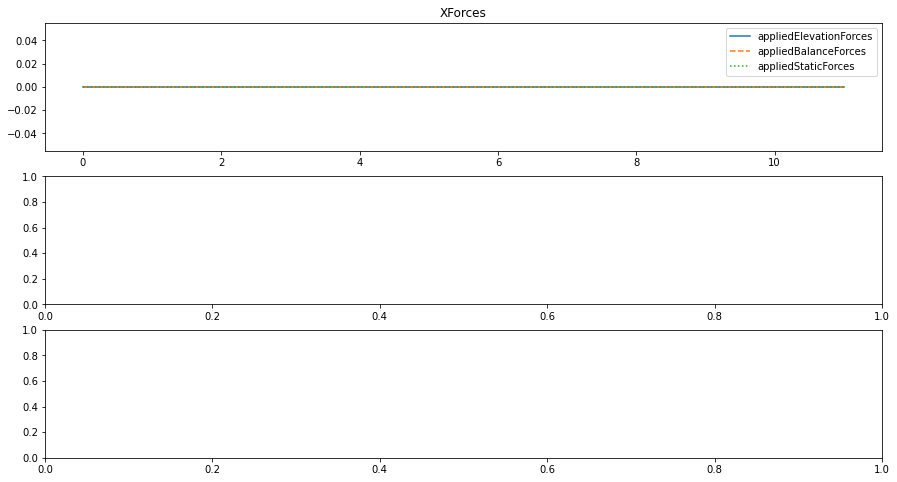

In [34]:
await vandv.m1m3.show_m1m3_forces_efd()

In [ ]:
# t_start = "2022-06-06T16:33:47.387"
# t_start = time.Time(t_start, format="isot", scale="tai")

# t_end = "2022-06-06T16:36:25.569"
# t_end = time.Time(t_end, format="isot", scale="tai")

## Plot Optics vs Time

Plot the following as a function of time during the above process:

- mount elevation
- m1m3 actuator 101 z force
- m2 actuator B1 force
- camera hex y position
- m2 hex y position

In [ ]:
t_start.utc

In [ ]:
df = await get_data_from_efd(
    exec_info.loc, 
    t_start, 
    t_end)

In [ ]:
df["elevation"].dropna()

In [ ]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=3, sharex=True)

axs[0].plot(df["elevation"].dropna(), "k", label="Mount Elevation")
axs[0].set_ylabel("Mount El\n[deg]")

axs[1].plot(df["mtm2.axialForce.applied0"].dropna(), "C1^-", label="applied")
axs[1].plot(df["mtm2.axialForce.lutGravity0"].dropna(), "C2v-", label="Gravity LUT")
axs[1].set_ylabel("M2 Forces\n[--]")

axs[2].plot(df["mthexapod_1.application.position1"].dropna(), "C3x-", label="CamHex Y")
axs[2].plot(df["mthexapod_2.application.position1"].dropna(), "C4+-", label="M2Hex Y")
axs[2].set_ylabel("Hexapod Position\n[um]")

for ax in axs:
    ax.grid(":", alpha=0.5)
    ax.legend()

fig.suptitle(f"{test_execution} - M1M3/M2/Hexs/Elevation vs Time")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_execution}_m1m3_m2_hexs_el_vs_time.png")
plt.show()

In [ ]:
vandv.m1m3.plot_m1m3_and_elevation(df)a

In [ ]:
client = EfdClient("summit_efd")

dfm = await client.select_time_series('lsst.sal.MTMount.elevation', '*', t_start, t_end, 1)
dfm1m3 = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedElevationForces', '*', t_start, t_end, 1)
dfm2 = await client.select_time_series('lsst.sal.MTM2.axialForce', '*', t_start, t_end, 1)
dfh = await client.select_time_series('lsst.sal.MTHexapod.application', '*', t_start, t_end, 1)

idx1=dfh.MTHexapodID==1
dfh1 = dfh[idx1]
idx2=dfh.MTHexapodID==2
dfh2 = dfh[idx2]

fig, ax = plt.subplots(1,1, figsize=(15,4))
plt.plot(dfm.actualPosition, '--', label='mount elevation')
# plt.plot(dfm1m3.yForces0, label='M1M3 elevation y-force 101')
# plt.plot(dfm2.lutGravity0, label='M2 elevation force B1')
# plt.plot(dfh1.position1, label='Camera hexapod y')
# plt.plot(dfh2.position1, label='M2 hexapod y')
plt.grid()
plt.legend()

## M1M3 Elevation Forces vs LUT

Check the M1M3 elevation forces match what we expect from the implemented LUT.

In [ ]:
elevation = await mtcs.rem.mtmount.tel_elevation.aget(timeout=10.)
print(elevation, "\n")

The look-up table for X has basically zeroes.  
At least for now.  
So it does not make much sense evaluating it now.

The lut for Y has non-zeroes and zeroes values.  
in order to compare, we can drop the zeroes components.

For z, we are good. We can perform a direct comparison.

In [ ]:
lut_el_xforces = vandv.m1m3.lut_elevation_xforces(elevation.actualPosition)
lut_el_yforces = vandv.m1m3.lut_elevation_yforces(elevation.actualPosition)
lut_el_zforces = vandv.m1m3.lut_elevation_zforces(elevation.actualPosition)

In [ ]:
fel = await mtcs.rem.mtm1m3.evt_appliedElevationForces.aget(timeout=10.)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3))

ax.plot(fel.xForces, "C0^-", label="Applied")
ax.set_ylabel("Elevation xForces [??]")
ax.grid(":", alpha=0.2)
ax.legend()

fig.suptitle(f"{test_execution} - M1M3 Elevation Forces")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_execution}_m1m3_fel_xForces.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(15, 6), nrows=2, sharex=True)

axs[0].plot(fel.yForces, "C0^-", label="Applied")
axs[0].plot(lut_el_yforces[lut_el_yforces != 0], "C1v-", label="LUT")
axs[0].set_ylabel("Elevation yForces [??]")
axs[0].grid(":", alpha=0.2)
axs[0].legend()

axs[1].plot(fel.yForces - lut_el_yforces[lut_el_yforces != 0], label="Applied - LUT forces")
axs[1].set_ylabel("Elefation yForces \n difference [??]")
axs[1].grid(":", alpha=0.2)

fig.suptitle(f"{test_execution} - M1M3 Elevation yForces")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_execution}_m1m3_fel_yForces.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(15, 6), nrows=2, sharex=True)

axs[0].plot(fel.zForces, "C0^-", label="Applied")
axs[0].plot(lut_el_zforces, "C1v-", label="LUT")
axs[0].set_ylabel("Elevation zForces [??]")
axs[0].grid(":", alpha=0.2)
axs[0].legend()

axs[1].plot(fel.zForces - lut_el_zforces, label="Applied - LUT forces")
axs[1].set_ylabel("Elefation zForces \n difference [??]")
axs[1].grid(":", alpha=0.2)

fig.suptitle(f"{test_execution} - M1M3 Elevation zForces")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_execution}_m1m3_fel_zForces.png")
plt.show()

The following plots are extracted from Bo's Notebooks.  
The originals are in [lsst-ts/ts_notebooks/bxin/ptg2m1m3].

[lsst-ts/ts_notebooks/bxin/ptg2m1m3]: https://github.com/lsst-ts/ts_notebooks/blob/develop/bxin/ptg2m1m3/m1m3_diagnostic.ipynb

## M2 Elevation Forces vs LUT

Check the M2 elevation forces match what we expect from the implemented LUT.

In [ ]:
vandv.m2.plot_m2_actuators()

In [ ]:
axialForces = await mtcs.rem.mtm2.tel_axialForce.aget(timeout=2)
tangentForces = await mtcs.rem.mtm2.tel_tangentForce.aget(timeout=2)

In [ ]:
vandv.m2.plotM2Forces(axialForces, tangentForces)

## CamHex Vs LUT

Check the camera hexapod LUT compensations match what we expect from the implemented LUT

In [ ]:
a = mtcs.rem.mthexapod_1.evt_compensationOffset.get()
elevCoeff, tCoeff = vandv.hexapod.coeffs_from_lut(index=1)
elev = a.elevation

await vandv.hexapod.print_hexapod_position(mtcs.rem.mthexapod_1)    
await vandv.hexapod.print_predicted_compensation(elevCoeff, elev)
await vandv.hexapod.print_hexapod_uncompensation_values(mtcs.rem.mthexapod_1)
await vandv.hexapod.print_hexapod_compensation_values(mtcs.rem.mthexapod_1)

## M2Hex vs LUT

In [ ]:
a = mtcs.rem.mthexapod_1.evt_compensationOffset.get()
elevCoeff, tCoeff = vandv.hexapod.coeffs_from_lut(index=2)
elev = a.elevation

await vandv.hexapod.print_hexapod_uncompensation_values(mtcs.rem.mthexapod_2)
await vandv.hexapod.print_predicted_compensation(elevCoeff, elev)
await vandv.hexapod.print_hexapod_position(mtcs.rem.mthexapod_2)    
await vandv.hexapod.print_hexapod_compensation_values(mtcs.rem.mthexapod_2)

### Close up

In [ ]:
# Put the telescope back to the original position
# Specially if running at TTS
target = mtcs.radec_from_azel(az=0, el=80)

await mtcs.slew_icrs(ra=target.ra, dec=target.dec, rot_type=RotType.Physical, rot=0)
await mtcs.stop_tracking()

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mtaos"])

In [ ]:
await mtcs.lower_m1m3()

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mtm1m3"])

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mtm2"])

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mthexapod_1"])

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mthexapod_2"])

In [ ]:
if exec_info.loc == "summit":
    await mtcs.standby()

else:
    # Bring the system back to the original state
    await mtcs.set_state(
        state=salobj.State.ENABLED,
        components=[
            "mtm1m3", 
            "mtm2",
            "mthexapod_1",
            "mthexapod_2",
            "mtaos",
        ],
        overrides={
            "mtm1m3": "Default"
        }
    )

## Wrap Up

In [ ]:
await mtcs.lower_m1m3()

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mtm1m3", "mtm2", "mthexapod_1", "mthexapod_2"])

In [ ]:
await mtcs.set_state(state=salobj.State.ENABLED, components=["mtm2", "mthexapod_1", "mthexapod_2"])